In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import joblib
import io
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')
df_sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')
df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


In [4]:
df_test.head(10)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral
5,750005,Money Matters,Episode 43,34.44,Business,77.18,Sunday,Night,NaN,0.0,Neutral
6,750006,Mystery Matters,Episode 33,116.09,True Crime,27.57,Friday,Night,22.82,1.0,Positive
7,750007,Gadget Geek,Episode 24,54.59,Technology,94.86,Tuesday,Morning,94.76,1.0,Neutral
8,750008,Home & Living,Episode 87,92.69,Lifestyle,75.22,Friday,Night,72.63,0.0,Neutral
9,750009,True Crime Stories,Episode 76,100.65,True Crime,27.66,Tuesday,Evening,NaN,1.0,Negative


In [5]:
podcast_names = df['Podcast_Name'].unique()
podcast_names

array(['Mystery Matters', 'Joke Junction', 'Study Sessions',
       'Digital Digest', 'Mind & Body', 'Fitness First', 'Criminal Minds',
       'News Roundup', 'Daily Digest', 'Music Matters', 'Sports Central',
       'Melody Mix', 'Game Day', 'Gadget Geek', 'Global News',
       'Tech Talks', 'Sport Spot', 'Funny Folks', 'Sports Weekly',
       'Business Briefs', 'Tech Trends', 'Innovators', 'Health Hour',
       'Comedy Corner', 'Sound Waves', 'Brain Boost', "Athlete's Arena",
       'Wellness Wave', 'Style Guide', 'World Watch', 'Humor Hub',
       'Money Matters', 'Healthy Living', 'Home & Living',
       'Educational Nuggets', 'Market Masters', 'Learning Lab',
       'Lifestyle Lounge', 'Crime Chronicles', 'Detective Diaries',
       'Life Lessons', 'Current Affairs', 'Finance Focus', 'Laugh Line',
       'True Crime Stories', 'Business Insights', 'Fashion Forward',
       'Tune Time'], dtype=object)

In [6]:
podcast_names.size

48

In [7]:
number_episodes_list = []
for name in podcast_names:
    number_episodes_list.append(df[df['Podcast_Name'] == name]['Episode_Title'].unique().size)
print(number_episodes_list)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [8]:
df['Episode_Title'] = df['Episode_Title'].str.extract(r'(\d+)').astype(int)
df_test['Episode_Title'] = df_test['Episode_Title'].str.extract(r'(\d+)').astype(int)
df['Publication_Time'].unique()

array(['Night', 'Afternoon', 'Evening', 'Morning'], dtype=object)

In [9]:
def publication_time_encoder(df, name_column: str):
    new_publication_time_cos = []
    new_publication_time_sin = []
    for value in df[name_column]:
        if value == 'Morning':
            new_publication_time_cos.append(1)
            new_publication_time_sin.append(0)
        elif value == 'Afternoon':  
            new_publication_time_cos.append(0)
            new_publication_time_sin.append(1)
        elif value == 'Evening':  
            new_publication_time_cos.append(-1)
            new_publication_time_sin.append(0)
        elif value == 'Night':  
            new_publication_time_cos.append(0)
            new_publication_time_sin.append(-1)

    df_new = df.copy()
    df_new = df_new.drop(columns=['Publication_Time'])
    df_new['Publication_Time_cos'] = new_publication_time_cos
    df_new['Publication_Time_sin'] = new_publication_time_sin
    return df_new
df = publication_time_encoder(df, 'Publication_Time')
df_test = publication_time_encoder(df_test, 'Publication_Time')
df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Publication_Time_cos,Publication_Time_sin
0,0,Mystery Matters,98,NaN,True Crime,74.81,Thursday,NaN,0.0,Positive,31.41998,0,-1
1,1,Joke Junction,26,119.80,Comedy,66.95,Saturday,75.95,2.0,Negative,88.01241,0,1
2,2,Study Sessions,16,73.90,Education,69.97,Tuesday,8.97,0.0,Negative,44.92531,-1,0
3,3,Digital Digest,45,67.17,Technology,57.22,Monday,78.70,2.0,Positive,46.27824,1,0
4,4,Mind & Body,86,110.51,Health,80.07,Monday,58.68,3.0,Neutral,75.61031,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,25,75.66,Education,69.36,Saturday,NaN,0.0,Negative,56.87058,1,0
749996,749996,Business Briefs,21,75.75,Business,35.21,Saturday,NaN,2.0,Neutral,45.46242,0,-1
749997,749997,Lifestyle Lounge,51,30.98,Lifestyle,78.58,Thursday,84.89,0.0,Negative,15.26000,1,0
749998,749998,Style Guide,47,108.98,Lifestyle,45.39,Thursday,93.27,0.0,Negative,100.72939,1,0


In [10]:
def publication_day_encoder(df_orig, name_column: str):
    df = df_orig.copy()
    
    # Відповідність дня тижня числу (Monday=0, Sunday=6)
    day_to_num = {
        'Monday': 0,
        'Tuesday': 1,
        'Wednesday': 2,
        'Thursday': 3,
        'Friday': 4,
        'Saturday': 5,
        'Sunday': 6
    }

    df[name_column] = df[name_column].map(day_to_num)

    # Циклічне кодування
    df[name_column + '_cos'] = np.cos(2 * np.pi * df[name_column] / 7)
    df[name_column + '_sin'] = np.sin(2 * np.pi * df[name_column] / 7)

    df = df.drop(columns=[name_column])

    return df
df = publication_day_encoder(df, 'Publication_Day')
df_test = publication_day_encoder(df_test, 'Publication_Day')
df['Episode_Sentiment'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

In [11]:
def episode_sentiment_encoder(df_orig, name_column: str):
    df = df_orig.copy()
    new_column = []
    for value in df[name_column]:
        if value == 'Positive':
            new_column.append(1)
        elif value == 'Negative':  
            new_column.append(-1)
        elif value == 'Neutral':  
            new_column.append(0)

    df[name_column] = new_column
    return df
df = episode_sentiment_encoder(df, 'Episode_Sentiment')
df_test = episode_sentiment_encoder(df_test, 'Episode_Sentiment')
genres = df['Genre'].unique()
genres

array(['True Crime', 'Comedy', 'Education', 'Technology', 'Health',
       'News', 'Music', 'Sports', 'Business', 'Lifestyle'], dtype=object)

In [12]:
genres_distribution_columns = [genre for genre in genres]
def make_genres_distribution(df_orig):
    df = df_orig.copy()
    
    # Створюємо масиви для подкастів і нульових значень
    podcast_names_values = np.array([podcast_names]).T
    genres_distribution_values = np.zeros((len(podcast_names), len(genres_distribution_columns)))
    
    # Об'єднуємо подкастові і жанрові дані
    genres_distribution_concat = np.concatenate((podcast_names_values, genres_distribution_values), axis=1)
    
    # Створюємо DataFrame
    df_gd = pd.DataFrame(genres_distribution_concat, columns=['Podcast_Name'] + genres_distribution_columns)
    
    # Заповнюємо таблицю жанровими даними
    for i, name in enumerate(podcast_names):
        # Отримуємо лічильники жанрів для кожного подкасту
        d = df[df['Podcast_Name'] == name]['Genre'].value_counts().to_dict()
        
        # Для кожного жанру в колонках генеруємо значення
        for genre in genres:
            # Перевіряємо, чи є жанр у словнику, і оновлюємо відповідне значення в таблиці
            df_gd.loc[i, genre] = d.get(genre, 0)
    
    return df_gd
genres_distribution = make_genres_distribution(df)
genres_distribution

,Podcast_Name,True Crime,Comedy,Education,Technology,Health,News,Music,Sports,Business,Lifestyle
0,Mystery Matters,15976,5,3,2,2,4,1,2,2,5
1,Joke Junction,8,15039,1,4,3,1,6,4,1,7
2,Study Sessions,1,2,13006,3,15,2,6,6,7,5
3,Digital Digest,14,2,4,16135,2,4,1,2,0,7
4,Mind & Body,3,3,7,3,13612,3,2,1,0,5
5,Fitness First,4,6,1,3,19434,1,5,14,1,19
6,Criminal Minds,17697,4,7,1,1,7,3,5,4,6
7,News Roundup,2,0,0,2,0,9165,0,0,0,0
8,Daily Digest,4,5,0,2,4,13357,1,12,2,4
9,Music Matters,0,3,0,0,1,0,12648,0,0,0


In [13]:
df = df.drop(columns=['Genre'])
df_test = df_test.drop(columns=['Genre'])
df_minutes = df[['Episode_Length_minutes', 'Listening_Time_minutes']]
df_minutes = df_minutes.dropna()
df_minutes_describe = df_minutes.describe()
df_minutes_describe['part'] = df_minutes_describe['Listening_Time_minutes'] / df_minutes_describe['Episode_Length_minutes'] * 100
df_minutes_describe

,Episode_Length_minutes,Listening_Time_minutes,part
count,662907.000000,662907.000000,100.000000
mean,64.504738,45.737987,70.906399
std,32.969603,27.269080,82.709760
min,0.000000,0.000000,NaN
25%,35.730000,23.252190,65.077498
50%,63.840000,43.743500,68.520520
75%,94.070000,65.196070,69.305910
max,325.240000,119.970000,36.886607


In [14]:
listening_time_minutes_means = {}
for name in podcast_names:
    listening_time_minutes_means[name] = df[df['Podcast_Name'] == name]['Listening_Time_minutes'].mean()
listening_time_minutes_means

{'Mystery Matters': 46.018360613673295,
 'Joke Junction': 42.640908867586575,
 'Study Sessions': 47.04778003217651,
 'Digital Digest': 44.76923695318781,
 'Mind & Body': 46.84007788034314,
 'Fitness First': 45.6236023953202,
 'Criminal Minds': 43.548437747392164,
 'News Roundup': 42.70749529501582,
 'Daily Digest': 45.69765708162198,
 'Music Matters': 46.08915354963642,
 'Sports Central': 41.80034794947811,
 'Melody Mix': 48.10555321774578,
 'Game Day': 44.10996828196347,
 'Gadget Geek': 47.02773935748138,
 'Global News': 45.43394204557111,
 'Tech Talks': 46.15922418348142,
 'Sport Spot': 44.70558380227365,
 'Funny Folks': 45.09001027298192,
 'Sports Weekly': 46.96599734852641,
 'Business Briefs': 47.121102945567834,
 'Tech Trends': 44.555054505601305,
 'Innovators': 45.87042657244636,
 'Health Hour': 45.21231335252834,
 'Comedy Corner': 43.930313746468265,
 'Sound Waves': 44.57401199956921,
 'Brain Boost': 44.40965067833319,
 "Athlete's Arena": 46.634790940151206,
 'Wellness Wave': 45

In [15]:
listening_time_minutes_mean = df['Listening_Time_minutes'].mean()
df['Episode_Length_minutes'] = df['Episode_Length_minutes'].fillna(listening_time_minutes_mean * 0.7)
df_test['Episode_Length_minutes'] = df_test['Episode_Length_minutes'].fillna(listening_time_minutes_mean * 0.7)
df[df['Number_of_Ads'].isna()]

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Publication_Time_cos,Publication_Time_sin,Publication_Day_cos,Publication_Day_sin
247170,247170,Game Day,33,35.66,27.35,49.87,NaN,-1,23.94516,-1,0,-0.900969,-0.433884


In [16]:
df[(df['Podcast_Name'] == 'Game Day') & (df['Episode_Title'] == 33) & (df['Publication_Time_cos'] == -1) & (df['Publication_Time_sin'] == 0)]['Number_of_Ads'].median()

1.0

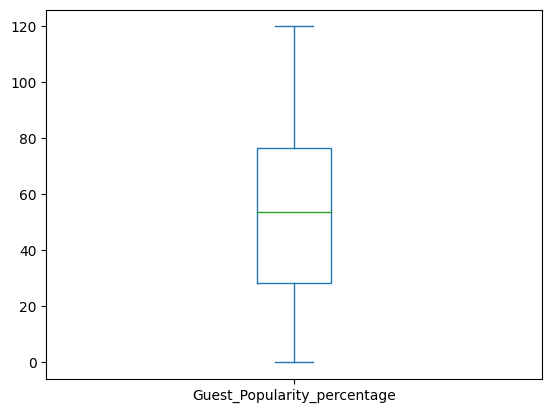

In [17]:
df['Number_of_Ads'] = df['Number_of_Ads'].fillna(1.0)
df.plot.box(
    column='Guest_Popularity_percentage',
)
plt.show()


In [18]:
guest_popularity_percentage_mean = df['Guest_Popularity_percentage'].mean()
df['Guest_Popularity_percentage'] = df['Guest_Popularity_percentage'].fillna(guest_popularity_percentage_mean)
df_test['Guest_Popularity_percentage'] = df_test['Guest_Popularity_percentage'].fillna(guest_popularity_percentage_mean)
df.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Host_Popularity_percentage     0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
Publication_Time_cos           0
Publication_Time_sin           0
Publication_Day_cos            0
Publication_Day_sin            0
dtype: int64

In [19]:
df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Publication_Time_cos,Publication_Time_sin,Publication_Day_cos,Publication_Day_sin
0,0,Mystery Matters,98,31.806184,74.81,52.236449,0.0,1,31.41998,0,-1,-0.900969,0.433884
1,1,Joke Junction,26,119.800000,66.95,75.950000,2.0,-1,88.01241,0,1,-0.222521,-0.974928
2,2,Study Sessions,16,73.900000,69.97,8.970000,0.0,-1,44.92531,-1,0,0.623490,0.781831
3,3,Digital Digest,45,67.170000,57.22,78.700000,2.0,1,46.27824,1,0,1.000000,0.000000
4,4,Mind & Body,86,110.510000,80.07,58.680000,3.0,0,75.61031,0,1,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,25,75.660000,69.36,52.236449,0.0,-1,56.87058,1,0,-0.222521,-0.974928
749996,749996,Business Briefs,21,75.750000,35.21,52.236449,2.0,0,45.46242,0,-1,-0.222521,-0.974928
749997,749997,Lifestyle Lounge,51,30.980000,78.58,84.890000,0.0,-1,15.26000,1,0,-0.900969,0.433884
749998,749998,Style Guide,47,108.980000,45.39,93.270000,0.0,-1,100.72939,1,0,-0.900969,0.433884


In [20]:
name_to_num = {name: i for i, name in enumerate(podcast_names)}
# Створення енкодера
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Навчання на train + трансформація обох
encoder.fit(df[['Podcast_Name']])

train_encoded = encoder.transform(df[['Podcast_Name']])
test_encoded = encoder.transform(df_test[['Podcast_Name']])

encoder_columns = encoder.get_feature_names_out(['Podcast_Name'])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder_columns, index=df.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder_columns, index=df_test.index)

df = df.drop(columns=['Podcast_Name'])
df = pd.concat([df, train_encoded_df], axis=1)

df_test = df_test.drop(columns=['Podcast_Name'])
df_test = pd.concat([df_test, test_encoded_df], axis=1)
df

,id,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Publication_Time_cos,Publication_Time_sin,...,Podcast_Name_Sports Central,Podcast_Name_Sports Weekly,Podcast_Name_Study Sessions,Podcast_Name_Style Guide,Podcast_Name_Tech Talks,Podcast_Name_Tech Trends,Podcast_Name_True Crime Stories,Podcast_Name_Tune Time,Podcast_Name_Wellness Wave,Podcast_Name_World Watch
0,0,98,31.806184,74.81,52.236449,0.0,1,31.41998,0,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,26,119.800000,66.95,75.950000,2.0,-1,88.01241,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,16,73.900000,69.97,8.970000,0.0,-1,44.92531,-1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,45,67.170000,57.22,78.700000,2.0,1,46.27824,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,86,110.510000,80.07,58.680000,3.0,0,75.61031,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,25,75.660000,69.36,52.236449,0.0,-1,56.87058,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
749996,749996,21,75.750000,35.21,52.236449,2.0,0,45.46242,0,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
749997,749997,51,30.980000,78.58,84.890000,0.0,-1,15.26000,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
749998,749998,47,108.980000,45.39,93.270000,0.0,-1,100.72939,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_test.head(10)

,id,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Publication_Time_cos,Publication_Time_sin,Publication_Day_cos,...,Podcast_Name_Sports Central,Podcast_Name_Sports Weekly,Podcast_Name_Study Sessions,Podcast_Name_Style Guide,Podcast_Name_Tech Talks,Podcast_Name_Tech Trends,Podcast_Name_True Crime Stories,Podcast_Name_Tune Time,Podcast_Name_Wellness Wave,Podcast_Name_World Watch
0,750000,73,78.96,38.11,53.330000,1.0,0,-1,0,-0.222521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,750001,23,27.87,71.29,52.236449,0.0,0,1,0,0.623490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,750002,11,69.10,67.89,97.510000,0.0,1,-1,0,-0.900969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,750003,73,115.39,23.40,51.750000,2.0,1,1,0,0.623490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,750004,50,72.32,58.10,11.300000,2.0,0,1,0,-0.222521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,750005,43,34.44,77.18,52.236449,0.0,0,0,-1,0.623490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,750006,33,116.09,27.57,22.820000,1.0,1,0,-1,-0.900969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,750007,24,54.59,94.86,94.760000,1.0,0,1,0,0.623490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,750008,87,92.69,75.22,72.630000,0.0,0,0,-1,-0.900969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,750009,76,100.65,27.66,52.236449,1.0,-1,-1,0,0.623490,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
X = df.drop(columns=['Listening_Time_minutes', 'id'])
y = df['Listening_Time_minutes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
def model_regression_report(model, X_test, y_test):
    # Прогнозування
    y_pred = model.predict(X_test)
    
    # Оцінка за допомогою метрик регресії
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    # print(f"Regression report for the model {model_name}:")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
def grid_search_fun(alg, param_grid, X, y):
    grid_search = GridSearchCV(
        alg,
        param_grid,
        scoring="neg_root_mean_squared_error",
        cv=5,
    )

    grid_search.fit(X, y)

    print("Best parameters:", grid_search.best_params_)
    print("Best accuracy:", grid_search.best_score_)

In [23]:
param_grid_LGBMR = {
    # 'boosting_type': ['gbdt'],
    # 'num_leaves': [261, 271],
    'max_depth': [61, 71, 81],
    # 'num_leaves': [501],
    # 'max_depth': [251],
    # 'learning_rate': [0.1, 0.5],
    # 'n_estimators': [1000, 1100],
    # 'subsample': [1.0, 0.8, 0.6],
    # 'colsample_bytree': [1.0, 0.9, 0.8],
    # 'reg_alpha': [0, 0.1, 0.5],
    # 'reg_lambda': [0, 0.1, 0.5],
    # 'min_child_samples': [40, 50, 60],
    # 'min_split_gain': [0.1, 0.5, 1.0],
}
GrS_LGBMR = 0
if GrS_LGBMR:
    grid_search_fun(
        LGBMRegressor(
            boosting_type = 'gbdt',
            num_leaves = 261,
            max_depth = 71,
            n_estimators = 1000,
            min_child_samples = 50,
            colsample_bytree = 0.8,
        ),
        param_grid_LGBMR,
        X_train,
        y_train,
    )
model_LGBMR = LGBMRegressor(
            boosting_type = 'gbdt',
            num_leaves = 261,
            max_depth = 71,
            n_estimators = 1000,
            min_child_samples = 50,
            colsample_bytree = 0.8,
)
model_LGBMR.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 991
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 58
[LightGBM] [Info] Start training from score 45.434051


LGBMRegressor(colsample_bytree=0.8, max_depth=71, min_child_samples=50,
              n_estimators=1000, num_leaves=261)

In [24]:
model_regression_report(
    model_LGBMR, X_test, y_test
)

Root Mean Squared Error (RMSE): 12.834500483020552


In [25]:
df_test.drop(columns=['id'])

,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Publication_Time_cos,Publication_Time_sin,Publication_Day_cos,Publication_Day_sin,...,Podcast_Name_Sports Central,Podcast_Name_Sports Weekly,Podcast_Name_Study Sessions,Podcast_Name_Style Guide,Podcast_Name_Tech Talks,Podcast_Name_Tech Trends,Podcast_Name_True Crime Stories,Podcast_Name_Tune Time,Podcast_Name_Wellness Wave,Podcast_Name_World Watch
0,73,78.96,38.11,53.330000,1.0,0,-1,0,-0.222521,-0.974928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23,27.87,71.29,52.236449,0.0,0,1,0,0.623490,-0.781831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,69.10,67.89,97.510000,0.0,1,-1,0,-0.900969,-0.433884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73,115.39,23.40,51.750000,2.0,1,1,0,0.623490,-0.781831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50,72.32,58.10,11.300000,2.0,0,1,0,-0.222521,0.974928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,100,21.05,65.77,96.400000,3.0,-1,-1,0,-0.222521,-0.974928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249996,85,85.50,41.47,30.520000,2.0,-1,0,-1,-0.222521,-0.974928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249997,63,12.11,25.92,73.690000,1.0,0,-1,0,-0.900969,0.433884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249998,46,113.46,43.47,93.590000,3.0,1,0,-1,-0.900969,-0.433884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
y_pred_test = model_LGBMR.predict(df_test.drop(columns=['id']))
df_sample_submission['id'] = df_test['id']
df_sample_submission['Listening_Time_minutes'] = y_pred_test
df_sample_submission

,id,Listening_Time_minutes
0,750000,54.945624
1,750001,18.946885
2,750002,47.328736
3,750003,74.524565
4,750004,49.366697
...,...,...
249995,999995,12.268783
249996,999996,57.430451
249997,999997,8.227474
249998,999998,70.080883


In [27]:
df_sample_submission.to_csv('submission.csv', index=False)